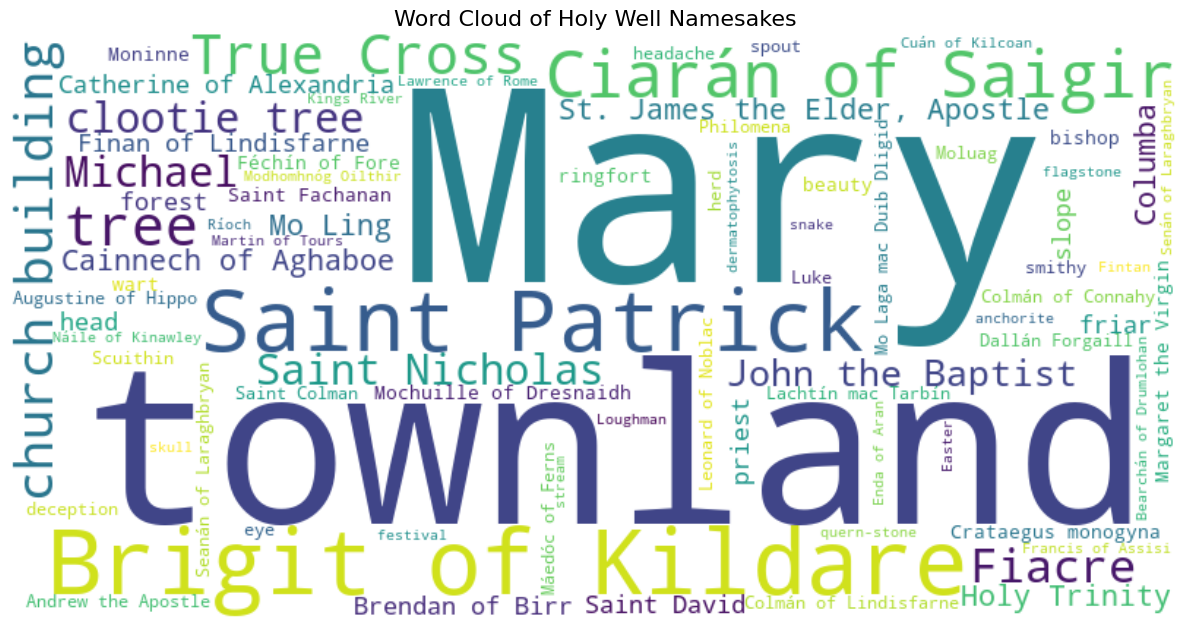

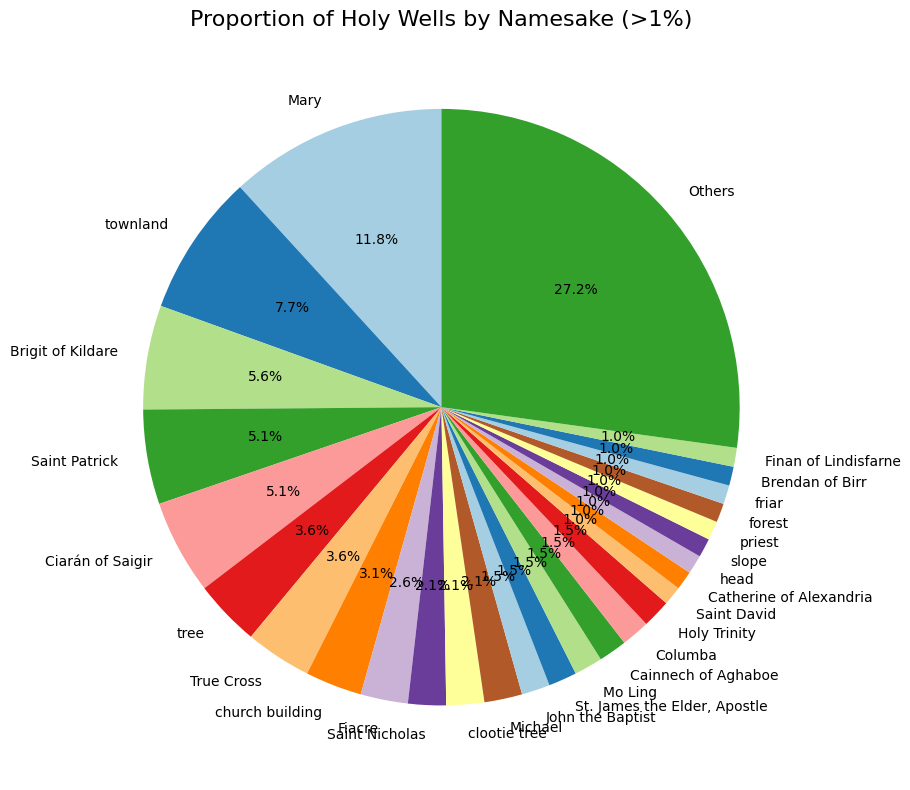

In [1]:

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to query Wikidata
def querySparql(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

# SPARQL Query for Holy Wells and Their Etymologies
holyWellsQuery = """
SELECT ?etymology ?etymologyLabel (COUNT(?HW) AS ?count)
WHERE
{
  ?HW wdt:P31 wd:Q126443332.
  ?HW wdt:P131 wd:Q180231.
  ?HW wdt:P138 ?etymology.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
GROUP BY ?etymology ?etymologyLabel
ORDER BY DESC(?count)
"""

# Fetch data using the SPARQL query
sparql_results = querySparql(holyWellsQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    data.append({
        "etymology": result['etymology']['value'],
        "etymologyLabel": result['etymologyLabel']['value'],
        "count": int(result['count']['value']),
    })

df = pd.DataFrame(data)

# Check if DataFrame is populated
if df.empty:
    print("No data retrieved from the query.")
else:
    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
        dict(zip(df["etymologyLabel"], df["count"]))
    )

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Holy Well Namesakes", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Generate Pie Chart with Filtering
    df_sorted = df.sort_values(by="count", ascending=False)
    total_count = df_sorted["count"].sum()

    # Filter namesakes > 1% and group the rest into "Others"
    df_sorted["percentage"] = (df_sorted["count"] / total_count) * 100
    df_filtered = df_sorted[df_sorted["percentage"] > 1]
    others_count = df_sorted[df_sorted["percentage"] <= 1]["count"].sum()

    # Add "Others" if applicable
    if others_count > 0:
        df_filtered = pd.concat(
            [
                df_filtered,
                pd.DataFrame({"etymologyLabel": ["Others"], "count": [others_count], "percentage": [others_count / total_count * 100]})
            ]
        )

    # Pie chart
    plt.figure(figsize=(12, 8))
    plt.pie(
        df_filtered["count"],
        labels=df_filtered["etymologyLabel"],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors
    )
    plt.title("Proportion of Holy Wells by Namesake (>1%)", fontsize=16)
    plt.tight_layout()
    plt.show()
